# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

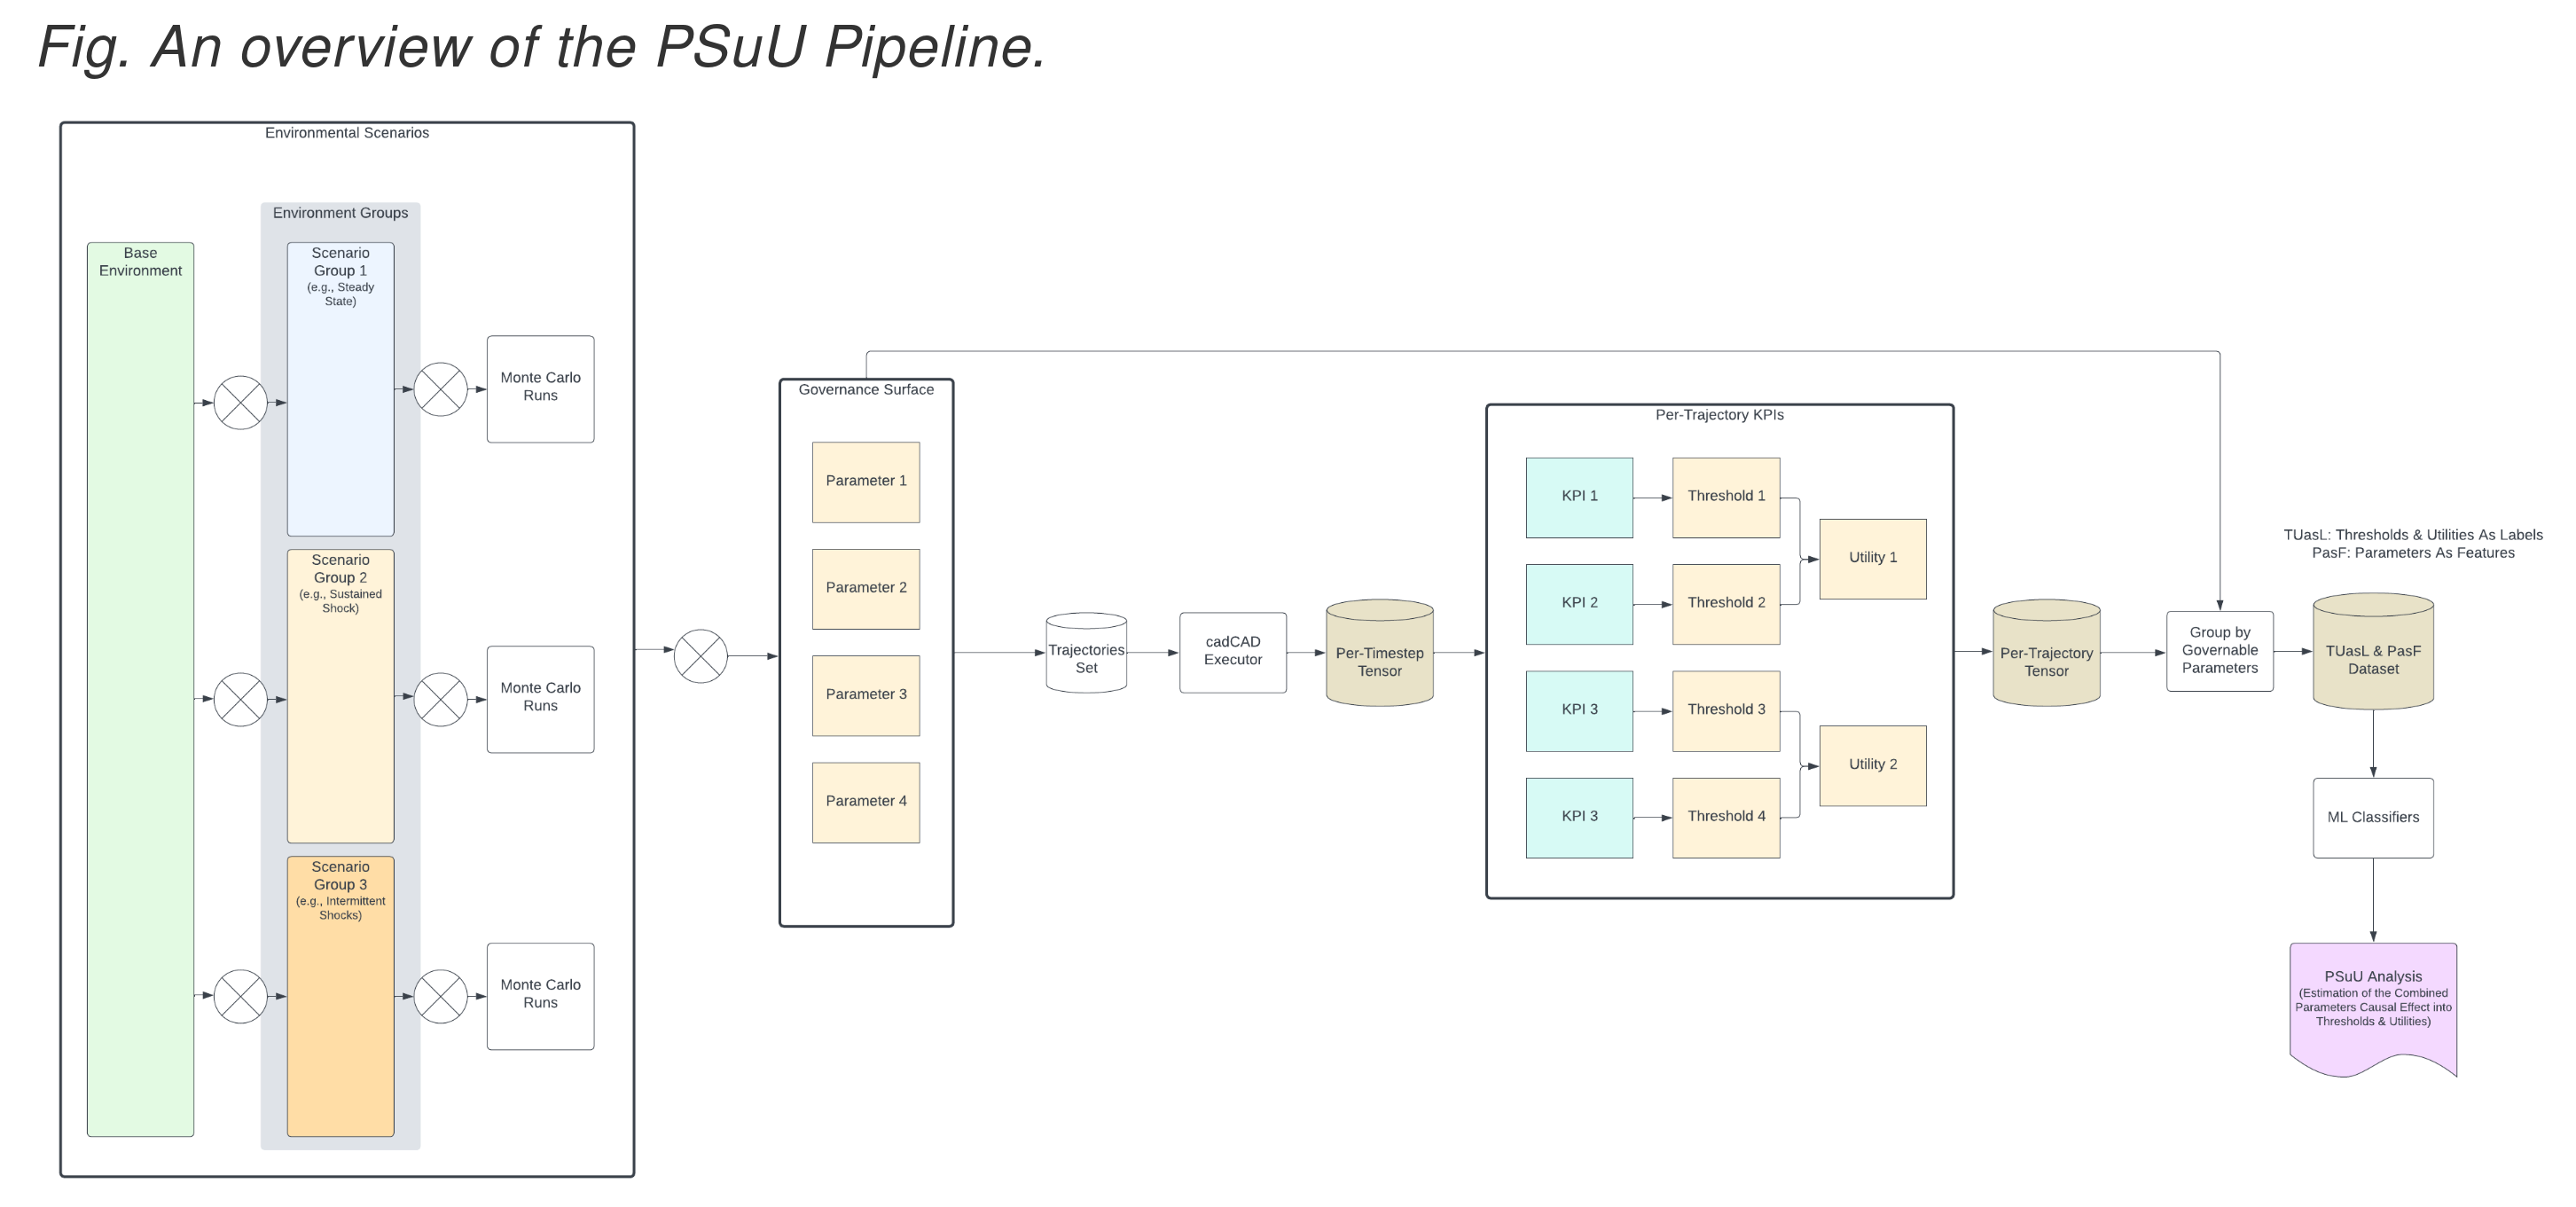

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import sys
sys.path.append('../../')

from glob import glob

latest = sorted(glob("../../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')


Check number of years per simulation.

In [2]:
sim_df['days_passed'].max() / 365

0.01643835616438356

Check percentage of total supply issued on average.

In [3]:
from subspace_model.const import MAX_CREDIT_ISSUANCE

sim_df['allocated_tokens'].max() / MAX_CREDIT_ISSUANCE

0.2915

In [4]:
sim_df

,timestep,days_passed,delta_days,delta_blocks,blocks_passed,circulating_supply,user_supply,issued_supply,sum_of_stocks,earned_supply,earned_minus_burned_supply,total_supply,block_utilization,compute_fee_volume,storage_fee_volume,rewards_to_nominators,per_recipient_reward,proposer_bonus_reward,reward_to_proposer,reward_to_voters,dsf_relative_disbursal_per_day,reward_issuance_balance,other_issuance_balance,operators_balance,nominators_balance,holders_balance,farmers_balance,staking_pool_balance,fund_balance,burnt_balance,nominator_pool_shares,operator_pool_shares,block_reward,blockchain_history_size,total_space_pledged,allocated_tokens,buffer_size,average_priority_fee,average_compute_weight_per_tx,average_transaction_size,transaction_count,average_compute_weight_per_bundle,average_bundle_size,bundle_count,storage_fee_per_rewards,avg_blockspace_usage,reference_subsidy,compute_fee_multiplier,free_space,extrinsic_length_in_bytes,storage_fee_in_credits_per_bytes,priority_fee_volume,consensus_extrinsic_fee_volume,max_normal_weight,max_bundle_weight,target_block_fullness,adjustment_variable,storage_fees_to_farmers,storage_fees_to_fund,target_block_delta,targeted_adjustment_parameter,tx_compute_weight,allocated_tokens_investors,allocated_tokens_founders,allocated_tokens_team,allocated_tokens_advisors,allocated_tokens_vendors,allocated_tokens_ambassadors,allocated_tokens_testnets,allocated_tokens_foundation,allocated_tokens_subspace_labs,allocated_tokens_ssl_priv_sale,community_owned_supply,cumm_rewards,cumm_storage_fees_to_farmers,cumm_compute_fees_to_farmers,simulation,subset,run,average_compute_weight_per_budle,label,environmental_label,timestep_in_days,reference_subsidy_components,block_time_in_seconds,weight_to_fee,reward_proposer_share,max_credit_supply
0,0,0.0,0.0,0.0,0.0,2.915000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.782000e+08,330300000.0,0.000000e+00,0.000000e+00,2.915000e+08,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,NaN,0,0,0.0,0.0,0.0,0.0,256,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52500000.0,150000000.0,70000000.0,19000000.0,0.000000e+00,0.0,0.0,0.0,0,0,1,NaN,standard,standard,1,"(SubsidyComponent(initial_period_start=30, ini...",6,1.000000e-14,0.333333,1000000000
15,1,1.0,1.0,14400.0,14400.0,5.830014e+08,5.830014e+08,6.218014e+08,1.000000e+09,0.0,0.0,6.218014e+08,0.0,1.000000e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.781986e+08,38800000.0,1.424778e+07,1.164350e+07,5.571100e+08,203.829499,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1437.985517,0,7758344052640065,291500000.0,93600000.0,0.0,60000000.0,256,0.0,0.0,0,86400.0,0.0,0.0,1437.985517,0.0,1.551669e+14,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52500000.0,150000000.0,70000000.0,19000000.0,7.176920e+08,NaN,0.0,0.0,0,0,1,1.000000e+10,standard,standard,1,"(SubsidyComponent(initial_period_start=30, ini...",6,1.000000e-14,0.333333,1000000000
30,2,2.0,1.0,14400.0,28800.0,5.808015e+08,5.830029e+08,6.218029e+08,1.000000e+09,0.0,0.0,6.218029e+08,0.0,1.000000e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.781971e+08,38800000.0,1.464189e+07,2.678129e+07,5.393780e+08,322.181380,2.201368e+06,0.0,0.0,8.246522e+05,1.376716e+06,1439.999008,268435456,10118481400333024,291500000.0,52982272.0,0.0,60000000.0,256,0.0,0.0,0,86400.0,0.0,0.0,1439.999008,0.0,2.023694e+14,0.0,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52500000.0,150000000.0,70000000.0,19000000.0,7.176934e+08,NaN,0.0,0.0,0,0,1,1.000000e+10,standard,standard,1,"(SubsidyComponent(initial_period_start=30, ini...",6,1.000000e-14,0.333333,1000000000
45,3,3.0,1.0,14400.0,43200.0,5.774541e+08,5.830043e+08,6.218043e+08,1.000000e+09,0.0,0.0,6.218043e+08,0.0,1.000000e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.781957e+08,38800000.0,1.021661e+07,3.630988e+07,5.309277e+08,0.000000,5.550179e+06,0.0,0.0,3.195618e+06,2.354561e+

Explode the reference subsidy parameter values.

In [5]:
i = 0
sim_df[f'component_{i+1}_initial_period_start'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_start)
sim_df[f'component_{i+1}_initial_period_duration'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_duration)
sim_df[f'component_{i+1}_max_cumulative_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_cumulative_subsidy)
sim_df[f'component_{i+1}_max_reference_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_reference_subsidy)

i = 1
sim_df[f'component_{i+1}_initial_period_start'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_start)
sim_df[f'component_{i+1}_initial_period_duration'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_duration)
sim_df[f'component_{i+1}_max_cumulative_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_cumulative_subsidy)
sim_df[f'component_{i+1}_max_reference_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_reference_subsidy)

## Part 3. Adding adhoc per-timestep metrics

#### T1: Average over Daily-Average Community Owned Supply Fraction

The Community Owned Supply (COS) is a sum of the following:
1. Vested Community owned supply
2. Community owned supply at launch
3. Issued to Farmers

1. Vested Community Owned Supply

From The Tokenomics Decision Making Forum from Subspace:

In [6]:
vested_community_ownded_supply_allocation = 1/33.03
vested_community_ownded_supply_allocation

0.030275507114744173

Note: `vested_tokens` and `allocated_tokens` are synonymous.

In [7]:
sim_df['vested_community_owned_supply'] = sim_df['allocated_tokens'] * vested_community_ownded_supply_allocation
sim_df['vested_community_owned_supply'].mean()

7564551.706241079

2. Community Owned Supply at Launch

In [8]:
from subspace_model.const import MAX_CREDIT_ISSUANCE

community_owned_supply_at_launch = 0.2225 * MAX_CREDIT_ISSUANCE
community_owned_supply_at_launch

222500000.0

3. Issued to Farmers

In [9]:
from subspace_model.const import ISSUANCE_FOR_FARMERS

sim_df['issued_to_farmers'] = ISSUANCE_FOR_FARMERS-sim_df['reward_issuance_balance']
sim_df['issued_to_farmers'].mean()

12224.946668735232

Community Owned Supply Fraction

In [10]:
import numpy as np

sim_df['community_owned_supply'] = sim_df['vested_community_owned_supply'] + community_owned_supply_at_launch + sim_df['issued_to_farmers']
sim_df['community_owned_supply_fraction'] = (sim_df['community_owned_supply'] / sim_df['total_supply']).replace(np.inf, np.nan)
sim_df['community_owned_supply_fraction'].mean()

0.37203966939581057

In [11]:
sim_df.query("subset == 1 & run == 1")['community_owned_supply_fraction']

Series([], Name: community_owned_supply_fraction, dtype: float64)

In [12]:
import hvplot.pandas

sim_df.hvplot.step(x='days_passed', y='community_owned_supply_fraction', by=['subset'], groupby=['run'], title="Community Owned Supply Fraction by Subset")

BokehModel(combine_events=True, render_bundle={'docs_json': {'dfc9460d-d772-4def-ba81-606af9e8ad36': {'version…

#### T2: Average over Daily-Average Farmer Subsidy Factor

Farmer Subsidy Factor

In [13]:
sim_df['storage_fees_to_farmers']

0       0.0
15      0.0
30      0.0
45      0.0
60      0.0
       ... 
1759    0.0
1774    0.0
1789    0.0
1804    0.0
1819    0.0
Name: storage_fees_to_farmers, Length: 1400, dtype: float64

In [14]:
sim_df

,timestep,days_passed,delta_days,delta_blocks,blocks_passed,circulating_supply,user_supply,issued_supply,sum_of_stocks,earned_supply,earned_minus_burned_supply,total_supply,block_utilization,compute_fee_volume,storage_fee_volume,rewards_to_nominators,per_recipient_reward,proposer_bonus_reward,reward_to_proposer,reward_to_voters,dsf_relative_disbursal_per_day,reward_issuance_balance,other_issuance_balance,operators_balance,nominators_balance,holders_balance,farmers_balance,staking_pool_balance,fund_balance,burnt_balance,nominator_pool_shares,operator_pool_shares,block_reward,blockchain_history_size,total_space_pledged,allocated_tokens,buffer_size,average_priority_fee,average_compute_weight_per_tx,average_transaction_size,transaction_count,average_compute_weight_per_bundle,average_bundle_size,bundle_count,storage_fee_per_rewards,avg_blockspace_usage,reference_subsidy,compute_fee_multiplier,free_space,extrinsic_length_in_bytes,storage_fee_in_credits_per_bytes,priority_fee_volume,consensus_extrinsic_fee_volume,max_normal_weight,max_bundle_weight,target_block_fullness,adjustment_variable,storage_fees_to_farmers,storage_fees_to_fund,target_block_delta,targeted_adjustment_parameter,tx_compute_weight,allocated_tokens_investors,allocated_tokens_founders,allocated_tokens_team,allocated_tokens_advisors,allocated_tokens_vendors,allocated_tokens_ambassadors,allocated_tokens_testnets,allocated_tokens_foundation,allocated_tokens_subspace_labs,allocated_tokens_ssl_priv_sale,community_owned_supply,cumm_rewards,cumm_storage_fees_to_farmers,cumm_compute_fees_to_farmers,simulation,subset,run,average_compute_weight_per_budle,label,environmental_label,timestep_in_days,reference_subsidy_components,block_time_in_seconds,weight_to_fee,reward_proposer_share,max_credit_supply,component_1_initial_period_start,component_1_initial_period_duration,component_1_max_cumulative_subsidy,component_1_max_reference_subsidy,component_2_initial_period_start,component_2_initial_period_duration,component_2_max_cumulative_subsidy,component_2_max_reference_subsidy,vested_community_owned_supply,issued_to_farmers,community_owned_supply_fraction
0,0,0.0,0.0,0.0,0.0,2.915000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.782000e+08,330300000.0,0.000000e+00,0.000000e+00,2.915000e+08,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,NaN,0,0,0.0,0.0,0.0,0.0,256,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52500000.0,150000000.0,70000000.0,19000000.0,2.225000e+08,0.0,0.0,0.0,0,0,1,NaN,standard,standard,1,"(SubsidyComponent(initial_period_start=30, ini...",6,1.000000e-14,0.333333,1000000000,30,0,7,0.1,30,2628000.0,1,0.3,0.000000e+00,0.000000,NaN
15,1,1.0,1.0,14400.0,14400.0,5.830014e+08,5.830014e+08,6.218014e+08,1.000000e+09,0.0,0.0,6.218014e+08,0.0,1.000000e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.781986e+08,38800000.0,1.424778e+07,1.164350e+07,5.571100e+08,203.829499,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1437.985517,0,7758344052640065,291500000.0,93600000.0,0.0,60000000.0,256,0.0,0.0,0,86400.0,0.0,0.0,1437.985517,0.0,1.551669e+14,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52500000.0,150000000.0,70000000.0,19000000.0,2.313267e+08,NaN,0.0,0.0,0,0,1,1.000000e+10,standard,standard,1,"(SubsidyComponent(initial_period_start=30, ini...",6,1.000000e-14,0.333333,1000000000,30,0,7,0.1,30,2628000.0,1,0.3,8.825310e+06,1437.985517,0.372027
30,2,2.0,1.0,14400.0,28800.0,5.808015e+08,5.830029e+08,6.218029e+08,1.000000e+09,0.0,0.0,6.218029e+08,0.0,1.000000e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.781971e+08,38800000.0,1.464189e+07,2.678129e+07,5.393780e+08,322.181380,2.201368e+06,0.0,0.0,8.246522e+05,1.376716e+06,1439.999008,268435456,10118481400333024,291500000.0,52982272.0,0.0,60000000.0,256,0.0,0.0,0,86400.0,0.0,0.0,1439.999008,0.0,2.023694e+14,0.0,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [15]:
sim_df.hvplot(x='days_passed', y=['reference_subsidy', 'storage_fees_to_farmers'], groupby=['subset', 'run'])

BokehModel(combine_events=True, render_bundle={'docs_json': {'85a09cf8-e46f-4b53-bb47-13ab7bd70bbb': {'version…

In [16]:
sim_df['farmer_subsidy_factor'] = sim_df['reference_subsidy'] / (sim_df['reference_subsidy']+sim_df['storage_fees_to_farmers'])

In [17]:
sim_df.hvplot.step(x='days_passed', y='farmer_subsidy_factor', by=['subset'], groupby=['run'], title="Farmer Subsidy Factor by Subset")

BokehModel(combine_events=True, render_bundle={'docs_json': {'1cec2e49-b1ee-4426-a912-1482fb826294': {'version…

#### T3: Average over Daily-Sum of Proposing Rewards per Newly Pledged Space

Proposer rewards cost factor

In [18]:
# proposer_reward = sim_df['reward_proposer_share'] * sim_df['block_reward'] + (1 - sim_df['reward_proposer_share']) * sim_df['block_reward'] / 10

## Part 3. Per-Trajectory KPIs

Threshold Rules

    BMaT: Below the Median across Trajectories
    LMaT: Larger than the Median across Trajectories

https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view#Per-Trajectory-Metrics

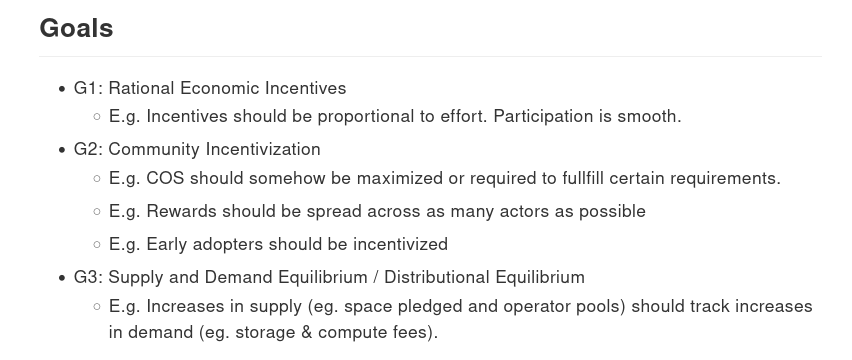

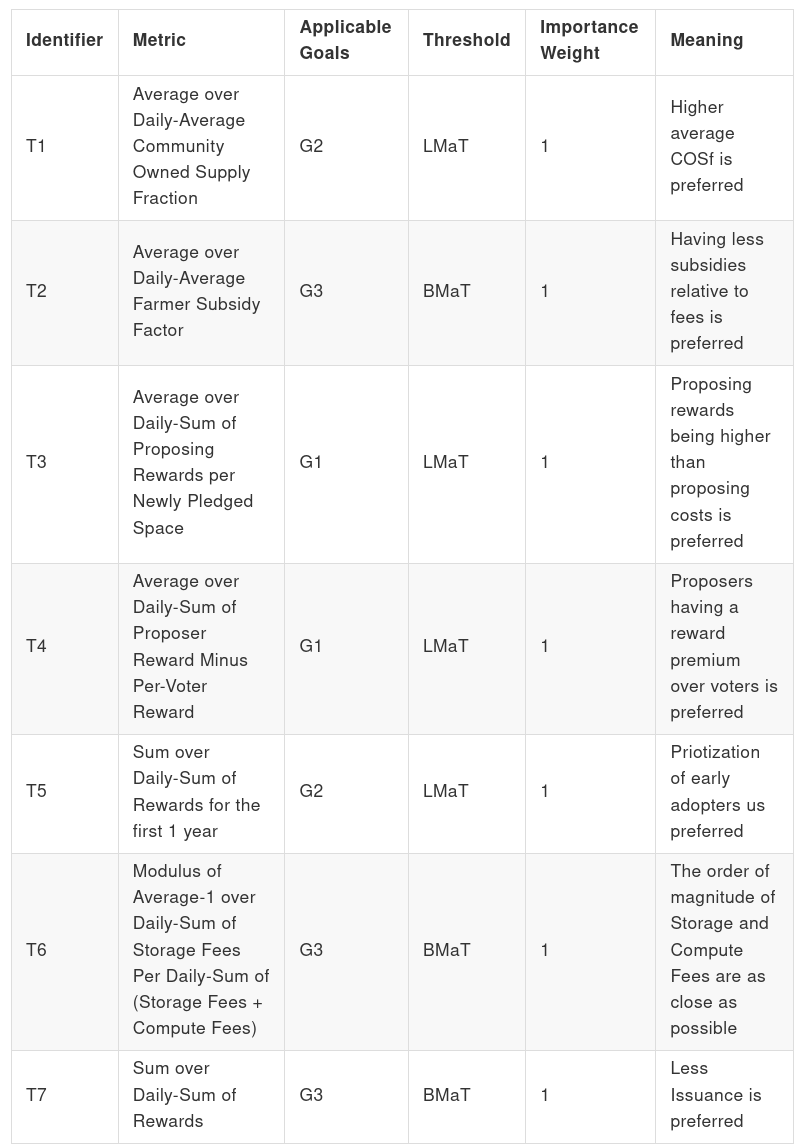

Create a set of governance surface parameters.

In [19]:
from subspace_model.params import GOVERNANCE_SURFACE

governance_surface_params = (set(GOVERNANCE_SURFACE.keys()) | {c for c in sim_df.columns if 'component' in c}) - {'reference_subsidy_components'}
governance_surface_params

{'component_1_initial_period_duration',
 'component_1_initial_period_start',
 'component_1_max_cumulative_subsidy',
 'component_1_max_reference_subsidy',
 'component_2_initial_period_duration',
 'component_2_initial_period_start',
 'component_2_max_cumulative_subsidy',
 'component_2_max_reference_subsidy',
 'reward_proposer_share',
 'weight_to_fee'}

Create the aggregation column list.

In [20]:
trajectory_id_columns = ['simulation', 'subset', 'run']
agg_columns = trajectory_id_columns + list(governance_surface_params)
agg_columns

['simulation',
 'subset',
 'run',
 'component_2_initial_period_duration',
 'component_1_max_cumulative_subsidy',
 'component_2_initial_period_start',
 'component_1_initial_period_start',
 'component_1_max_reference_subsidy',
 'component_2_max_cumulative_subsidy',
 'component_1_initial_period_duration',
 'component_2_max_reference_subsidy',
 'weight_to_fee',
 'reward_proposer_share']

In [21]:
def trajectory_average_community_owned_supply_fraction(trajectory_df) -> float:
    return trajectory_df.community_owned_supply_fraction.mean()

def trajectory_average_farmer_subsidy_factor(trajectory_df) -> float:
    return trajectory_df.farmer_subsidy_factor.mean()

KPIs_per_trajectory = {
    'average_community_owned_supply_fraction': trajectory_average_community_owned_supply_fraction,
    'average_farmer_subsidy_factor': trajectory_average_farmer_subsidy_factor,
}

In [22]:
kpi_dfs = []
for kpi, kpi_f in KPIs_per_trajectory.items():
    kpi_s = sim_df.groupby(agg_columns).apply(kpi_f)
    kpi_s.name = kpi
    kpi_dfs.append(kpi_s)


all_kpi_df = pd.concat(kpi_dfs, axis=1)

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_2483/983413712.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kpi_s = sim_df.groupby(agg_columns).apply(kpi_f)
/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_2483/983413712.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kpi_s = sim_df.groupby(agg_columns).apply(kpi_f)


In [23]:
all_kpi_df

average_community_owned_supply_fraction  \
simulation subset run component_2_initial_period_duration component_1_max_cumulative_subsidy component_2_initial_period_start component_1_initial_period_start component_1_max_reference_subsidy component_2_max_cumulative_subsidy component_1_initial_period_duration component_2_max_reference_subsidy weight_to_fee reward_proposer_share                                            
0          0      1   2628000.0                           7                                  30                               30                               0.1                               1                                  0                                   0.3                               1.000000e-14  0.333333                                              0.372030   
           1      2   21024000.0                          4                                  14                               14                               0.3                               7                                  0                                   0.5                               1.000000e-16  0.100000                                              0.372041   
           2      3   2628000.0                           7                                  14                               14                               0.3                               1                                  0                                   0.5                               1.000000e-16  0.333333                                              0.372041   
           3      4   10512000.0                          7                                  14                               14                               0.3                               4                                  0                                   0.5                               1.000000e-15  0.333333                                              0.372041   
           4      5   21024000.0                          4                                  14                               14                               0.1                               4                                  0                                   0.3                               1.000000e-14  0.333333                                              0.372030   
...                                                                                                                                                                                                                                                                                                                                                                                ...   
           195    16  2628000.0                           7                                  14                               14                               0.1                               1                                  0                                   0.1                               1.000000e-16  0.100000                                              0.372030   
           196    17  2628000.0                           7                                  14                               0                                0.3                               7                                  0                                   0.5                               1.000000e-14  0.333333                                              0.372041   
           197    18  10512000.0                          7                                  14                               0                                0.5                               4                                  0                                   0.5                               1.000000e-18  0.333333                                              0.372051   
           198    19  2628000.0                           7                                  14                               14                               0.1               

array([[<Axes: title={'center': 'average_community_owned_supply_fraction'}>,
        <Axes: title={'center': 'average_farmer_subsidy_factor'}>]],
      dtype=object)

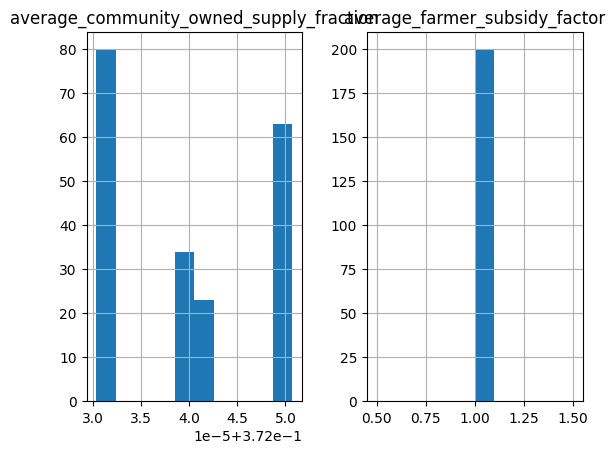

In [24]:
all_kpi_df.hist()

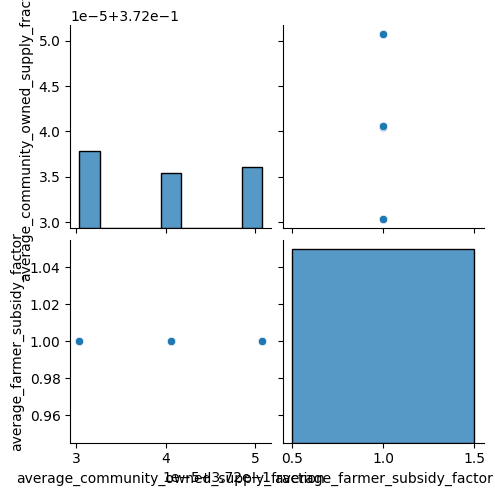

In [25]:
import seaborn as sns 
sns.pairplot(all_kpi_df.reset_index().drop(columns=trajectory_id_columns).drop(columns=list(governance_surface_params)))

In [26]:
threshold_df = all_kpi_df.copy(deep=True)


def transform_column_to_boolean_int(df, column_name, threshold_func):
    return threshold_func(df[column_name]).astype(int)

def threshold_greater_than_median(series):
    return series > series.median()

def threshold_less_than_median(series):
    return series < series.median()

threshold_per_KPI = {
    'average_community_owned_supply_fraction': threshold_greater_than_median,
    'average_farmer_subsidy_factor': threshold_less_than_median,
}

for kpi, func in threshold_per_KPI.items():
    threshold_df[kpi] = transform_column_to_boolean_int(all_kpi_df, kpi, func)


threshold_df

average_community_owned_supply_fraction  \
simulation subset run component_2_initial_period_duration component_1_max_cumulative_subsidy component_2_initial_period_start component_1_initial_period_start component_1_max_reference_subsidy component_2_max_cumulative_subsidy component_1_initial_period_duration component_2_max_reference_subsidy weight_to_fee reward_proposer_share                                            
0          0      1   2628000.0                           7                                  30                               30                               0.1                               1                                  0                                   0.3                               1.000000e-14  0.333333                                                     0   
           1      2   21024000.0                          4                                  14                               14                               0.3                               7                                  0                                   0.5                               1.000000e-16  0.100000                                                     1   
           2      3   2628000.0                           7                                  14                               14                               0.3                               1                                  0                                   0.5                               1.000000e-16  0.333333                                                     0   
           3      4   10512000.0                          7                                  14                               14                               0.3                               4                                  0                                   0.5                               1.000000e-15  0.333333                                                     1   
           4      5   21024000.0                          4                                  14                               14                               0.1                               4                                  0                                   0.3                               1.000000e-14  0.333333                                                     0   
...                                                                                                                                                                                                                                                                                                                                                                                ...   
           195    16  2628000.0                           7                                  14                               14                               0.1                               1                                  0                                   0.1                               1.000000e-16  0.100000                                                     0   
           196    17  2628000.0                           7                                  14                               0                                0.3                               7                                  0                                   0.5                               1.000000e-14  0.333333                                                     1   
           197    18  10512000.0                          7                                  14                               0                                0.5                               4                                  0                                   0.5                               1.000000e-18  0.333333                                                     1   
           198    19  2628000.0                           7                                  14                               14                               0.1               

In [27]:
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

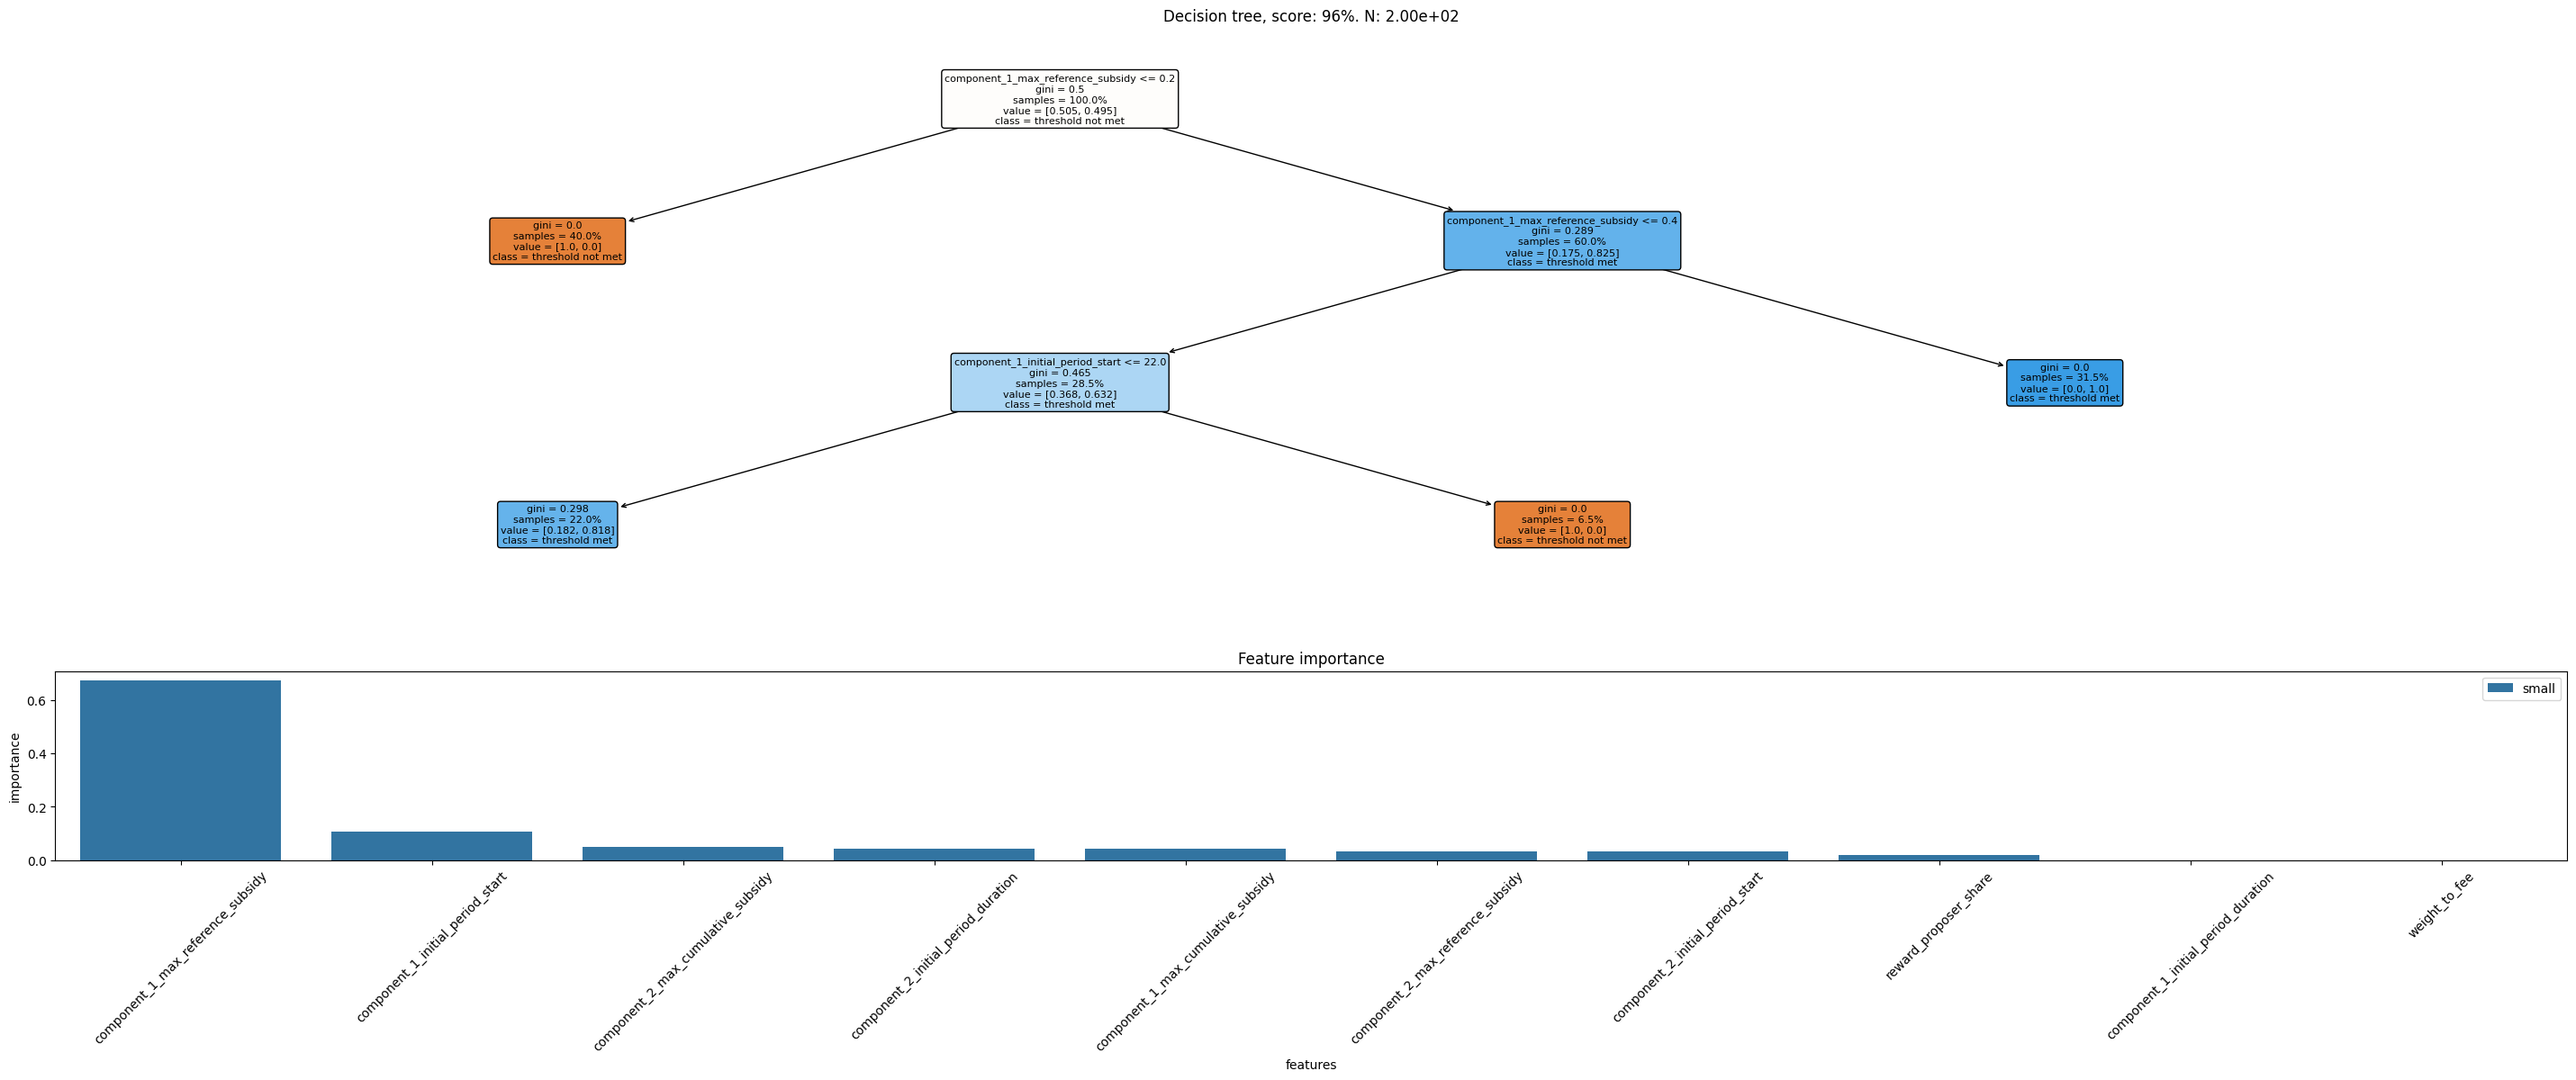

In [28]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


df = threshold_df.reset_index()
kpi = 'average_community_owned_supply_fraction'
features = list(set(governance_surface_params) - {kpi})
X = df.loc[:, features]
y = df.loc[:, kpi]

model = DecisionTreeClassifier(max_depth=3)
rf = RandomForestClassifier()
model.fit(X, y)
rf.fit(X, y)



rf_df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                    columns=['features', 'importance'])
        .sort_values(by='importance', ascending=False)
        )


fig, axes = plt.subplots(nrows=2,
                            figsize=(36, 12),
                            dpi=100,
                            gridspec_kw={'height_ratios': [3, 1]})

(ax_dt, ax_rf) = axes[0], axes[1]
plot_tree(model,
            rounded=True,
            proportion=True,
            fontsize=8,
            feature_names=X.columns,
            class_names=['threshold not met', 'threshold met'],
            filled=True,
            ax=ax_dt)
ax_dt.set_title(
    f'Decision tree, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
sns.barplot(data=rf_df,
            x=rf_df.features,
            y=rf_df.importance,
            ax=ax_rf,
            label='small')
plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
ax_rf.set_title(f'Feature importance')
plt.show()